# Decision Tree Attack and Uniform Extraction
TJ Kim, 26 Oct 2019

We build a decision tree classifier for the data in encoded_adult.csv. The inputs are all the encoded characteristics, while the output is whether or not the income is greater than 50k or not for a person (binary).

We get the class labels only as outputs. Therefore, we do a uniform attack that queries the classifier and uses the output as combinations to make a new trainer.

## Importing Data
First we import CSV data as pandas and divide to test and training set.

In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree

# Import Dataset
filename = "adult_encoded.csv"
df = pd.read_csv(filename, sep='\s*,\s*',engine = 'python')
df = df.loc[:,df.columns != 'Unnamed: 0']

# Separate each dataset into training, testing, and query data
total_rest,total_test = train_test_split(df, random_state=30, test_size=0.2, shuffle=True)
total_train,queries = train_test_split(total_rest,random_state = 30, test_size = 0.4, shuffle = True)

# Separate each sub dataset to input and output
total_train_data = total_train.loc[:,total_train.columns != 'income_over_50k']
total_train_label = total_train.loc[:,total_train.columns =='income_over_50k']
total_test_data = total_train.loc[:,total_test.columns != 'income_over_50k']
total_test_label = total_train.loc[:,total_test.columns =='income_over_50k']
query_data = queries.loc[:,queries.columns !='income_over_50k']
query_label = queries.loc[:,queries.columns =='income_over_50k']

## Build and Run Decision Tree

We use the train data to build a decision tree (of any arbitrary depth at the moment) and use the test data to obtain the accuracy.

In [2]:
# Build and train Decision Tree Classifier
model = tree.DecisionTreeClassifier()
model.fit(total_train_data,total_train_label)

# Prediction and Accuracy
from sklearn.metrics import accuracy_score
y_predict = model.predict(total_test_data)
accuracy_score(total_test_label,y_predict)

0.9787143283709423

The accuracy for the decision tree is significantly better for the logistic regression model. The logistic regression model has approximately 85% accuracy, while the decision tree has 98%. Maybe this is because the dataset we are using has many categorical inputs, which decision trees handle better.

## Utilize Uniform Label Attack to Steal decision tree

Here, we will attack the decision tree by querying the tree and using the output to train our own tree.

In [3]:
# Obtain query labels and then build own decision tree
y_query = model.predict(query_data)
model_stolen = tree.DecisionTreeClassifier()
model_stolen.fit(query_data,y_query)

# Prediction and Accuracy
y_q_predict = model_stolen.predict(total_test_data)
accuracy_score(total_test_label,y_q_predict)

0.8469905728788978

We observe that the accuracy significantly suffers as it falls from 98% to 85% with the uniform attack model. However, that is still very high considering that we attempt a very naive attack.

## Sweep number of queries against performance

Next, we will sweep the number of queries to see how accuracy increases as we query more.

In [4]:
query_num1 = np.arange(5,100,2)
query_num2 = np.arange(100,y_query.size,100)
query_num = np.concatenate([query_num1, query_num2])
accs = np.zeros(query_num.size)
og_acc = np.zeros(query_num.size)
accs_idx = 0

for num in query_num:
    # take subset of query data and obtain labels from real classifier
    samp = query_data.sample(n=num)
    sweep_labels = model.predict(samp)
    # Build stolen classifier with output data
    model_sweep = tree.DecisionTreeClassifier()
    model_sweep.fit(samp,sweep_labels)
    sweep_pred = model_sweep.predict(total_test_data)
    accs[accs_idx] = accuracy_score(total_test_label,sweep_pred)
    
    y_pred = model.predict(total_train_data)
    og_acc[accs_idx] = model.score(total_test_data, total_test_label)
    
    accs_idx += 1

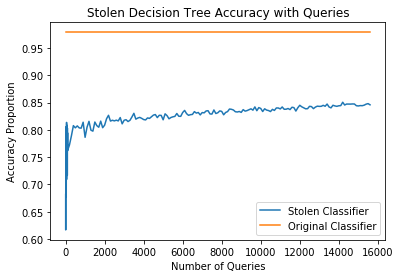

In [5]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Decision Tree Accuracy with Queries")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")

plt.gca().legend(('Stolen Classifier','Original Classifier'))